# Prueba con análisis FEM

Resolver la ecuación diferencial parcial del calor.

$$\dfrac{\partial}{\partial t}u(x, t) = \dfrac{\partial^2}{\partial t^2}u(x,t) + f(x, t)$$

Con Condiciones de Borde de Dirichlet Homogénea $u(0, t) = u(1, t) = 0$

y una fuente de calor $f(x, t)$.

In [1]:
from mpi4py import MPI
from dolfinx import fem, mesh
from dolfinx.fem import Function, FunctionSpace

domain = mesh.create_unit_square(
    MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral
)

V = FunctionSpace(domain, ("Lagrange", 1))
uD = Function(V)
uD.interpolate(lambda x: 1 + x[0] ** 2 + 2 * x[1] ** 2)

uD

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False), (2,)), 0), Basix element (P, quadrilateral, 1, gll_warped, unset, False)), 0)

In [2]:
tdim = domain.topology.dim
fdim = tdim - 1

domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

## dirichlet boundary condiction
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)
bc

In [3]:
## defining trial and test function
import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

## defining the source term

from dolfinx import default_scalar_type
f = fem.Constant(domain, default_scalar_type(-6))

## defining the variational problem

a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

L

Form([Integral(Product(Constant(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False), (2,)), 0), (), 0), Argument(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False), (2,)), 0), Basix element (P, quadrilateral, 1, gll_warped, unset, False)), 0, None)), 'cell', Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False), (2,)), 0), 'everywhere', {}, None)])

In [4]:
## forming and solving the linear system

from dolfinx.fem.petsc import LinearProblem
problem = LinearProblem(
    a, L, bcs=[bc], 
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu"
    }
)
uh = problem.solve()
uh

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 1, gll_warped, unset, False), (2,)), 0), Basix element (P, quadrilateral, 1, gll_warped, unset, False)), 1)

In [5]:
## computing the error
import numpy as np

V2 = fem.FunctionSpace(domain, ("Lagrange", 2))
uex = fem.Function(V2)
uex.interpolate(lambda x: 1 + x[0] ** 2 + 2 * x[1] ** 2)

L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))
error_L2

error_max = np.max(np.abs(uD.x.array - uD.x.array))

if domain.comm.rank == 0:
    print(f"Error L2: {error_L2:.2e}")
    print(f"Error_max: {error_max:.2e}")

Error L2: 8.24e-03
Error_max: 0.00e+00


In [8]:
## plotting the mesh using pyvista
import pyvista
print(pyvista.global_theme.jupyter_backend)

trame


In [12]:
from dolfinx import plot
pyvista.start_xvfb()
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
grid

UnstructuredGrid,Information
N Cells,64
N Points,81
X Bounds,"0.000e+00, 1.000e+00"
Y Bounds,"0.000e+00, 1.000e+00"
Z Bounds,"0.000e+00, 0.000e+00"
N Arrays,0



No module named 'trame'

Falling back to a static output.
  warnings.warn(



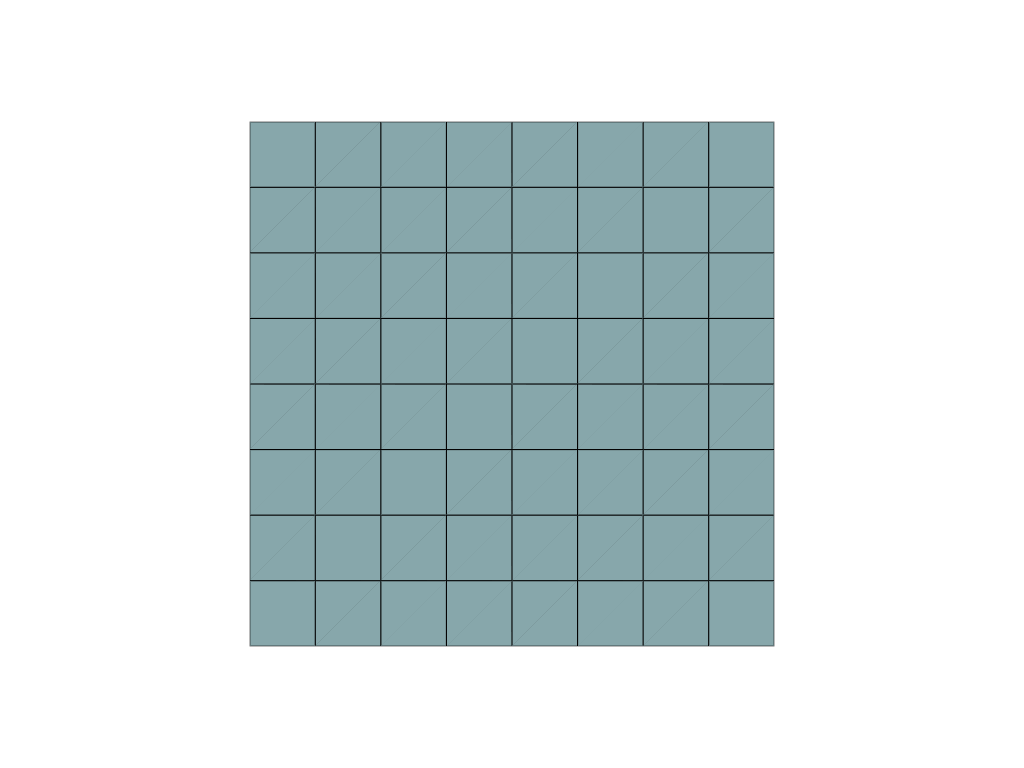

In [13]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")